# Lecture 15: Class demo

Let's cluster images!!

![](../../img/eva-fun-times.png)

For this demo, I'm going to use the following image dataset: 
1. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5) from last lecture
(available [here](https://github.ubc.ca/mds-2021-22/datasets/blob/master/data/food.zip)).
2. A small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)).

To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

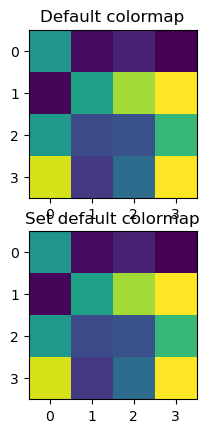

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from plotting_functions_unsup import *

import torch
import torchvision
from torchvision import datasets, models, transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
set_seed(seed=42)

In [5]:
import glob
IMAGE_SIZE = 224
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [6]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [7]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    model.eval()
    with torch.no_grad():  # turn off computational graph stuff        
        Z = model(inputs).detach().numpy()         
    return Z

In [8]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [9]:
data_dir = "../../data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir)
n_images

350

In [10]:
X_food = food_inputs.numpy()

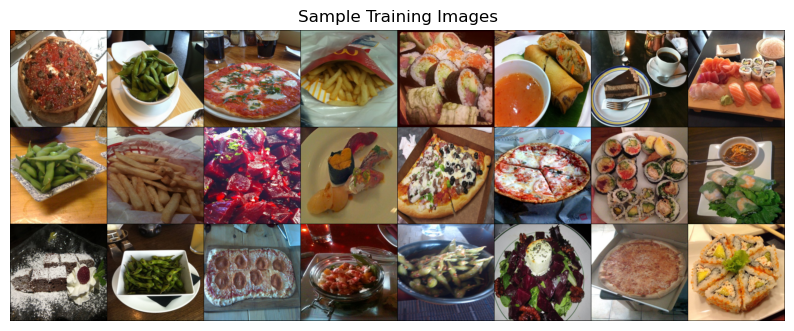

In [11]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [12]:
Z_food = get_features(
    densenet, food_inputs, 
)

In [13]:
Z_food.shape

(350, 1024)

In [14]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

KMeans(n_clusters=5, random_state=123)

In [15]:
km.cluster_centers_.shape

(5, 1024)

244
Image indices:  [244 249 214 273 171 327]


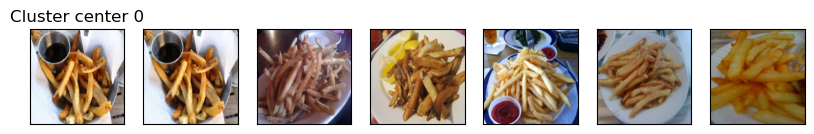

48
Image indices:  [ 48 191 265 334 343 138]


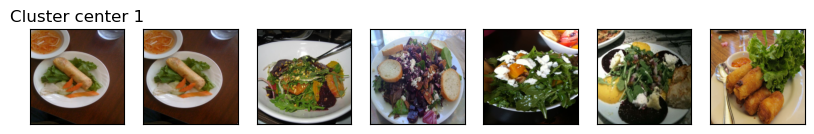

76
Image indices:  [ 76 138 313  61 190  48]


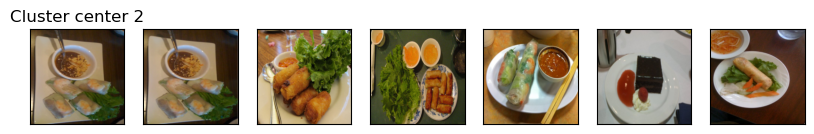

274
Image indices:  [274 203  89 330 209 205]


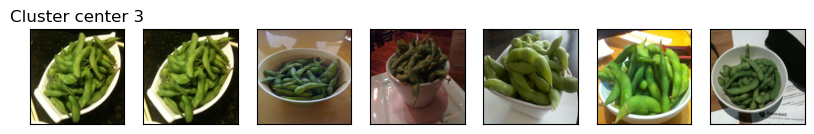

124
Image indices:  [124  27  25 253 280 223]


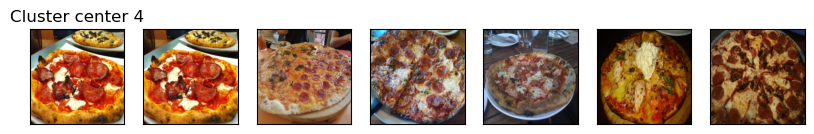

In [16]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

<br><br>

## DBSCAN

In [17]:
dbscan = DBSCAN()

labels = dbscan.fit_predict(Z_food)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


It identified all points as noise points. Let's explore the distances between points. 

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(Z_food)
np.fill_diagonal(dists, np.inf)
dists_df = pd.DataFrame(dists)
dists_df

0          1          2          3          4          5    \
0          inf  27.170071  23.031963  29.344770  27.464485  25.905249   
1    27.170071        inf  22.623034  24.378839  25.491880  21.179726   
2    23.031963  22.623034        inf  28.764124  25.544821  23.159750   
3    29.344770  24.378839  28.764124        inf  28.520519  23.345842   
4    27.464485  25.491880  25.544821  28.520519        inf  21.172096   
..         ...        ...        ...        ...        ...        ...   
345  26.458879  23.107458  25.684532  21.547804  25.304211  22.533875   
346  28.636688  21.258495  26.029633  26.480219  25.343542  21.611742   
347  23.513239  19.471357  20.417009  24.750483  23.945749  19.392572   
348  26.565344  20.257633  21.786682  25.170492  23.584101  19.035461   
349  27.202259  22.101439  22.903080  26.520855  25.460316  21.709145   

           6          7          8          9    ...        340        341  \
0    28.601198  27.226374  27.482910  27.221531  ...  27.895405  28.627741   
1    25.291134  22.400309  17.118835  23.523659  ...  22.605665  19.422024   
2    26.158792  23.423162  23.352556  25.552364  ...  26.763525  25.627256   
3    28.131287  27.448313  24.425112  19.679516  ...  22.209080  26.940434   
4    26.477964  23.458084  24.881807  26.123215  ...  26.482233  24.862644   
..         ...        ...        ...        ...  ...        ...        ...   
345  26.831314  24.927710  22.792894  21.153376  ...  20.873131  24.183716   
346  26.205795  25.979353  20.662205  23.817640  ...  22.648527  21.091988   
347  23.914520  22.881351  20.868397  23.173370  ...  23.511862  23.249804   
348  22.507225  21.890001  18.954798  24.086985  ...  24.703289  22.101406   
349  24.901802  24.091793  23.649513  25.744673  ...  26.223894  25.669897   

           342        343        344        345        346        347  \
0    28.157877  24.296236  27.864172  26.458879  28.636688  23.513239   
1    22.297949  20.873529  24.695156  23.107458  21.258495  19.471357   
2    27.411240  22.771511  24.695322  25.684532  26.029633  20.417009   
3    26.980894  25.166636  27.609039  21.547804  26.480219  24.750483   
4    26.194008  22.634832  26.464815  25.304211  25.343542  23.945749   
..         ...        ...        ...        ...        ...        ...   
345  25.783266  23.444523  25.757412        inf  24.095852  22.627153   
346  21.743132  23.498381  27.345236  24.095852        inf  22.860329   
347  23.443993  17.126707  22.055302  22.627153  22.860329        inf   
348  23.019146  18.728836  22.244556  24.188885  24.492994  18.786024   
349  25.911024  18.624897  25.121590  24.653475  25.513124  18.716599   

           348        349  
0    26.565344  27.202259  
1    20.257633  22.101439  
2    21.786682  22.903080  
3    25.170492  26.520855  
4    23.584101  25.460316  
..         ...        ...  
345  24.188885  24.653475  
346  24.492994  25.513124  
347  18.786024  18.716599  
348        inf  22.293304  
349  22.293304        inf  

[350 rows x 350 columns]

In [19]:
dists.min(), np.nanmax(dists[dists != np.inf]), np.mean(dists[dists != np.inf])

(10.06717, 36.652683, 24.538565)

In [20]:
for eps in range(13, 20):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(Z_food)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=13
Number of clusters: 2
Cluster sizes: [347   3]

eps=14
Number of clusters: 5
Cluster sizes: [334   3   6   4   3]

eps=15
Number of clusters: 4
Cluster sizes: [299  26   8  17]

eps=16
Number of clusters: 4
Cluster sizes: [248  86   3  13]

eps=17
Number of clusters: 2
Cluster sizes: [205 145]

eps=18
Number of clusters: 2
Cluster sizes: [160 190]

eps=19
Number of clusters: 2
Cluster sizes: [116 234]


In [21]:
dbscan = DBSCAN(eps=14, min_samples=3)
dbscan_labels = dbscan.fit_predict(Z_food)
print("Number of clusters: {}".format(len(np.unique(dbscan_labels))))
print("Cluster sizes: {}".format(np.bincount(dbscan_labels + 1)))
print("Unique labels: {}".format(np.unique(dbscan_labels)))

Number of clusters: 5
Cluster sizes: [334   3   6   4   3]
Unique labels: [-1  0  1  2  3]


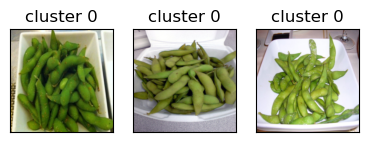

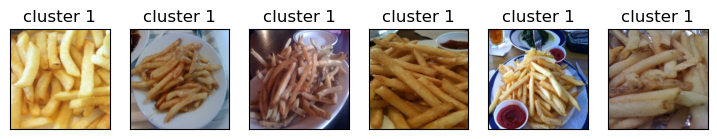

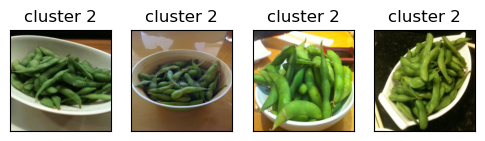

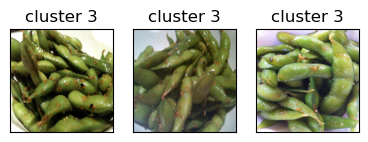

In [22]:
print_dbscan_clusters(Z_food, food_inputs, dbscan_labels)

Let's examine noise points identified by DBSCAN. 

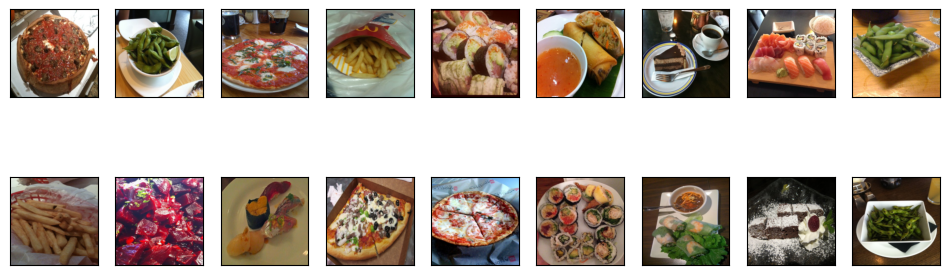

In [23]:
print_dbscan_noise_images(Z_food, food_inputs, dbscan_labels)

<br><br>

### Hierarchical clustering

In [24]:
set_seed(seed=42)

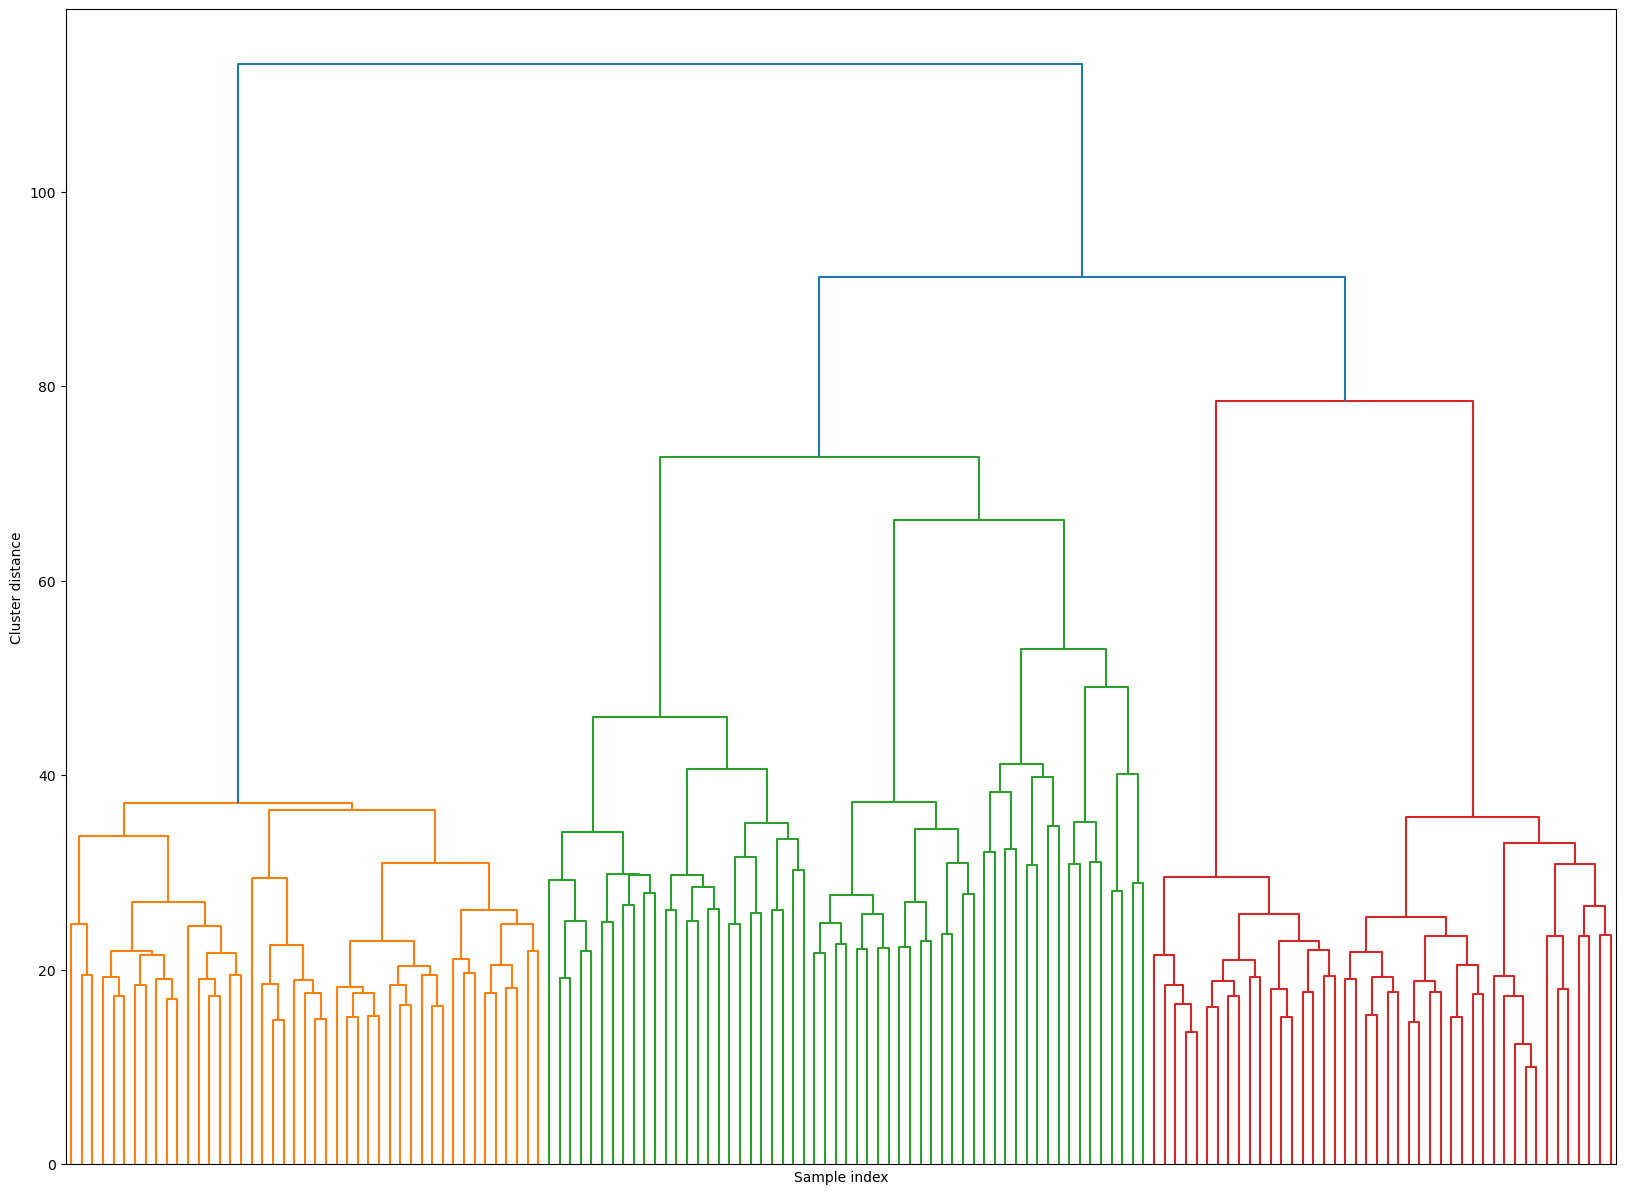

In [26]:
plt.figure(figsize=(20, 15))
Z_hrch = ward(Z_food)
dendrogram(Z_hrch, p=7, truncate_mode="level", no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance");

In [29]:
cluster_labels = fcluster(Z_hrch, 20, criterion="maxclust")  # let's get flat clusters

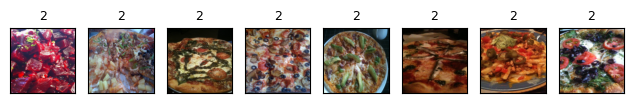

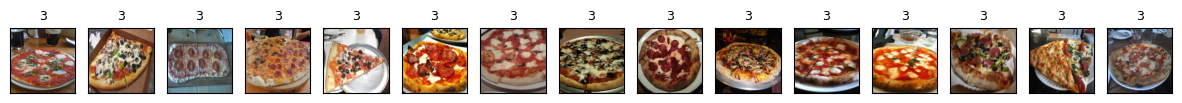

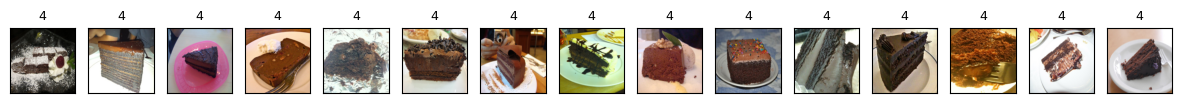

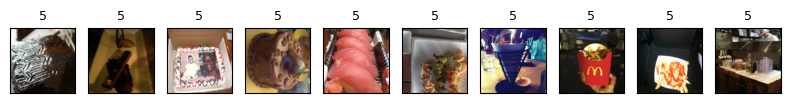

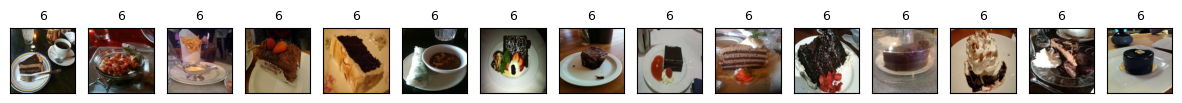

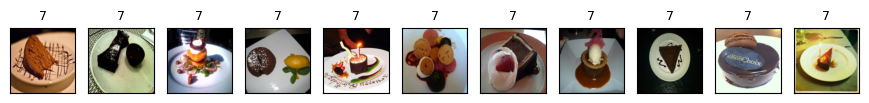

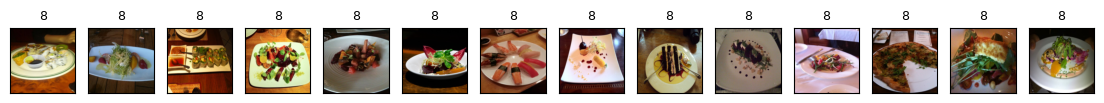

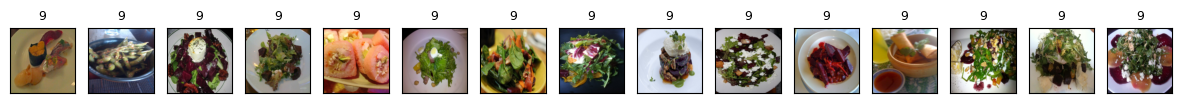

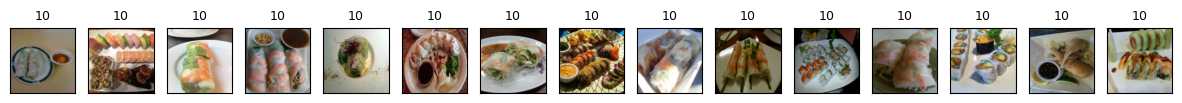

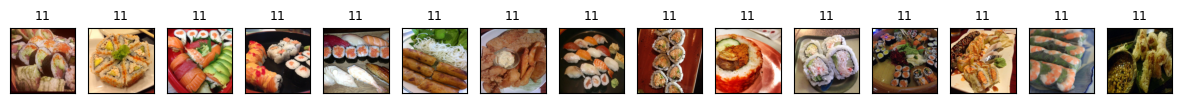

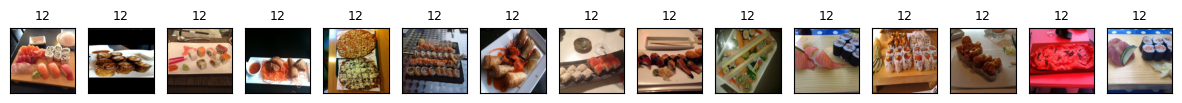

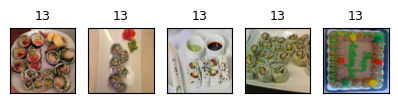

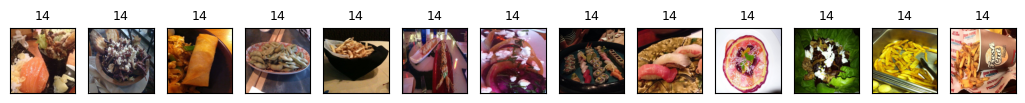

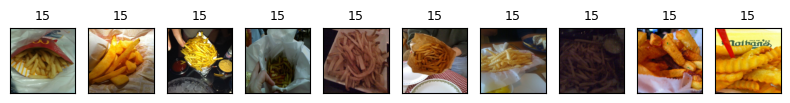

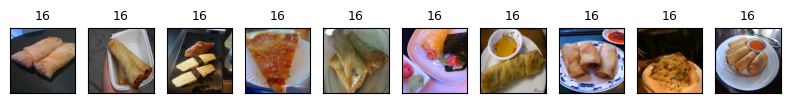

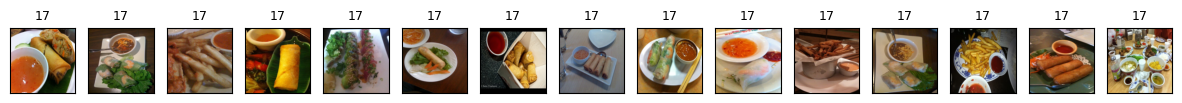

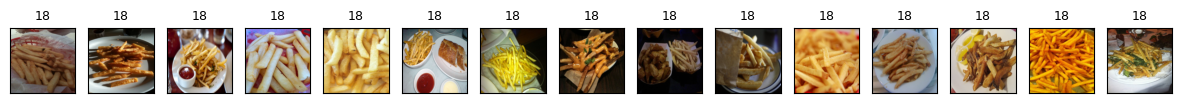

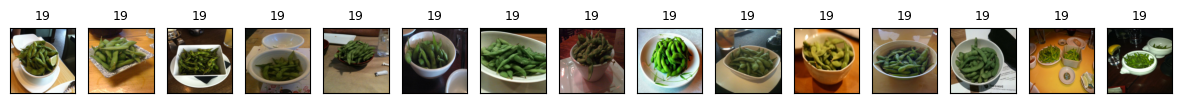

In [33]:
hand_picked_clusters = np.arange(2, 20)
#hand_picked_clusters = [2, 3, 5, 6,7, 8, 9, 10, 12, 14,15,16,17,19,20, 21,22, 24, 26, 27, 28]
print_hierarchical_clusters(
    food_inputs, Z_food, cluster_labels, hand_picked_clusters
)

- Some clusters correspond to people with distinct faces, age, facial expressions, hair colour and hair style, lighting and skin tone. 